# Summary
> ## TODO
> ### DATA
1.   Analyze in detail model errors on dublin dataset
2.   Find a better dataset to fine tune BERT

> ### MODEL
1.   Try novel architectures like GPT3
2.   Train with complete dataset
3.   Add early stopping in training

> ### SOFTWARE
1.   Define a requirement with libraries versions to version problem. Ideally, create a docker file to solve operative system incompatibilities.
2.   Create technical and functional documentation.
3.   Create a file with parameters.
4.   Create unit testing of functions.
5.   Add Logger class.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd /content/gdrive/MyDrive/bert

/content/gdrive/MyDrive/bert


In [ ]:
%%capture
!git clone https://github.com/vonsovsky/bert-sentiment.git
!pip install transformers

In [ ]:
import re
import os

import numpy as np
import pandas as pd
import torch
from sklearn import metrics
import matplotlib.pyplot as plt

from transformers import BertTokenizer
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from transformers import TFBertModel

from preprocess_data import read_dublin_data, read_sentiment_data
from bert_model import bert_encode, create_model
from evaluate import plot_learning_curves, evaluate_model

In [ ]:
BATCH_SIZE = 32
NEURONS_HIDDEN = 64
LEARNING_RATE_MODEL = 1e-6
EPOCHS = 10
N_SAMPLE = 10000

In [ ]:
%%capture
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')

In [ ]:
%%capture
filename = "/content/gdrive/MyDrive/bert/Sentiment140-train.csv"
df = read_sentiment_data(filename)
df = df.sample(N_SAMPLE, random_state=1).reset_index(drop=True)

le = LabelEncoder()
le.fit(df['sentiment'])

df['target_encoded'] = le.transform(df['sentiment'])

texts = df['text']
target_train = df['target_encoded']

train_input_ids, train_attention_masks = bert_encode(texts, 128, tokenizer)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [ ]:
%%capture
filename = "/content/gdrive/MyDrive/bert/Sentiment140-test.csv"

df_test = read_sentiment_data(filename)
df_test['target_encoded'] = le.transform(df_test['sentiment'])

texts = df_test['text']
target_test = df_test['target_encoded']

test_input_ids, test_attention_masks = bert_encode(texts, 128, tokenizer)


In [ ]:
%%capture
filename = "/content/gdrive/MyDrive/bert/citypulse.dublin_city_council.test.csv"

df_dublin = read_dublin_data(filename)

df_dublin['target_encoded'] = le.transform(df_dublin['sentiment'])
texts = df_dublin['text']
target_dublin = df_dublin['target_encoded']

dublin_input_ids, dublin_attention_masks = bert_encode(texts, 128, tokenizer)

In [ ]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
model = create_model(bert_model, LEARNING_RATE_MODEL, NEURONS_HIDDEN)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 109482240   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           49216       tf_bert_model[0][1]          

In [ ]:
history = model.fit(
    [train_input_ids, train_attention_masks],
    target_train,
    validation_split=0.2, 
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

Epoch 1/10
250/250 [==============================] - 210s 806ms/step - loss: 0.7143 - accuracy: 0.5123 - val_loss: 0.6569 - val_accuracy: 0.6190
Epoch 2/10
250/250 [==============================] - 207s 828ms/step - loss: 0.6328 - accuracy: 0.6425 - val_loss: 0.5560 - val_accuracy: 0.7410
Epoch 3/10
250/250 [==============================] - 207s 828ms/step - loss: 0.5486 - accuracy: 0.7385 - val_loss: 0.4857 - val_accuracy: 0.7840
Epoch 4/10
250/250 [==============================] - 207s 828ms/step - loss: 0.4906 - accuracy: 0.7768 - val_loss: 0.4518 - val_accuracy: 0.8055
Epoch 5/10
250/250 [==============================] - 207s 828ms/step - loss: 0.4529 - accuracy: 0.8018 - val_loss: 0.4398 - val_accuracy: 0.8100
Epoch 6/10
250/250 [==============================] - 207s 828ms/step - loss: 0.4353 - accuracy: 0.8106 - val_loss: 0.4338 - val_accuracy: 0.8080
Epoch 7/10
250/250 [==============================] - 207s 828ms/step - loss: 0.4111 - accuracy: 0.8270 - val_loss: 0.4306 -

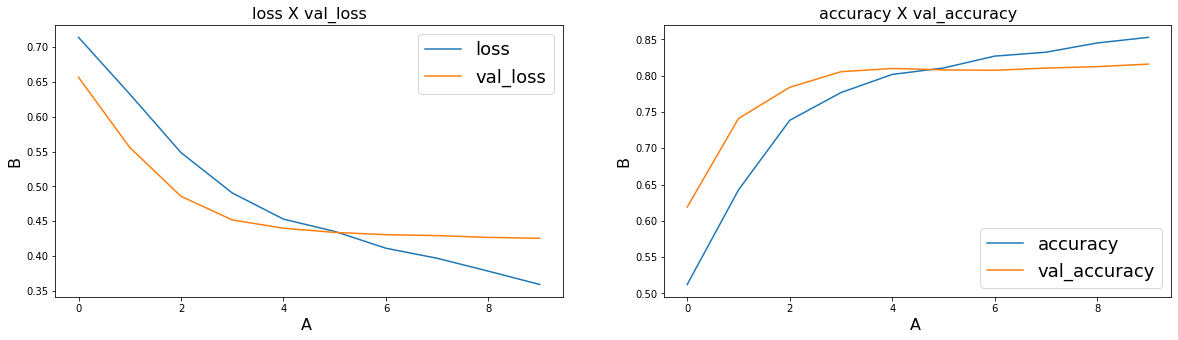

In [ ]:
plot_learning_curves(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

In [ ]:
predictions_test = model.predict([test_input_ids, test_attention_masks])
predictions_test_class = [i.round() for i in predictions_test]

y_pred_bi = np.array(predictions_test_class)
y_hat_bi = np.array(df_test['sentiment'])
evaluate_model(y_hat_bi, y_pred_bi)

[[144  33]
 [ 24 158]]
              precision    recall  f1-score   support

           0       0.86      0.81      0.83       177
           1       0.83      0.87      0.85       182

    accuracy                           0.84       359
   macro avg       0.84      0.84      0.84       359
weighted avg       0.84      0.84      0.84       359

Accuracy Score: 0.841


In [ ]:
predictions_dublin = model.predict([dublin_input_ids, dublin_attention_masks])
predictions_dublin_class = [i.round() for i in predictions_dublin]

y_pred_bi = np.array(predictions_dublin_class)
y_hat_bi = np.array(df_dublin['sentiment'])
evaluate_model(y_hat_bi, y_pred_bi)

[[674 326]
 [290 710]]
              precision    recall  f1-score   support

           0       0.70      0.67      0.69      1000
           1       0.69      0.71      0.70      1000

    accuracy                           0.69      2000
   macro avg       0.69      0.69      0.69      2000
weighted avg       0.69      0.69      0.69      2000

Accuracy Score: 0.692


In [ ]:
predictions_train = model.predict([train_input_ids, train_attention_masks])
predictions_train_class = [i.round() for i in predictions_train]

y_pred_bi = np.array(predictions_train_class)
y_hat_bi = np.array(df['sentiment'])
evaluate_model(y_hat_bi, y_pred_bi)

[[4271  732]
 [ 583 4414]]
              precision    recall  f1-score   support

           0       0.88      0.85      0.87      5003
           1       0.86      0.88      0.87      4997

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

Accuracy Score: 0.869
